<a href="https://colab.research.google.com/github/jignyik/airost_mask_detection_demo/blob/main/Airost_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

from zipfile import ZipFile
file_name = "/content/gdrive/MyDrive/DAT/face_mask_image_preprocessed.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Done


In [42]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [43]:
train_dir = os.path.join(r"/content/", 'Train')
validation_dir = os.path.join(r"/content/", 'Test')

BATCH_SIZE = 128
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)



Found 7737 files belonging to 3 classes.


In [44]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2402 files belonging to 3 classes.


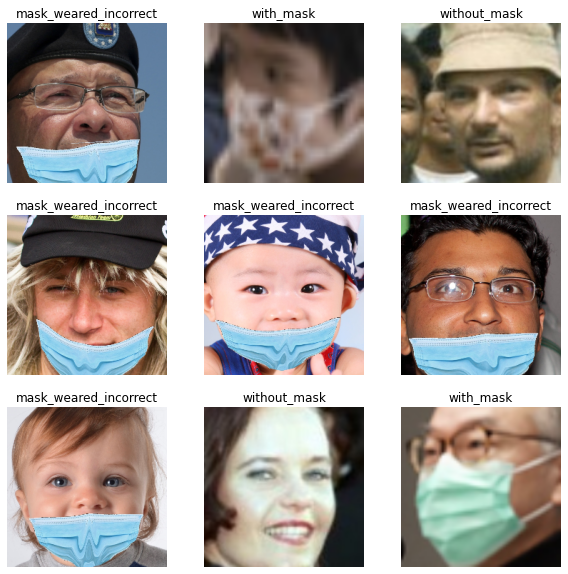

In [45]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [46]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [55]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu')
])

In [56]:
prediction_layer = tf.keras.layers.Dense(3, activation= "softmax")

In [57]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = model(inputs)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [58]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [59]:
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 128)               2456864   
                                                                 
 dense_10 (Dense)            (None, 3)                 387       
                                                                 
Total params: 2,457,251
Trainable params: 2,457,251
Non-trainable params: 0
_________________________________________________________________


In [60]:
epochs = 5

history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/5
61/61 [==============================] - 23s 332ms/step - loss: 0.9903 - accuracy: 0.4267 - val_loss: 0.9167 - val_accuracy: 0.4480
Epoch 2/5
61/61 [==============================] - 22s 330ms/step - loss: 0.7186 - accuracy: 0.8030 - val_loss: 0.5624 - val_accuracy: 0.8999
Epoch 3/5
61/61 [==============================] - 22s 331ms/step - loss: 0.4017 - accuracy: 0.9144 - val_loss: 0.3188 - val_accuracy: 0.9138
Epoch 4/5
61/61 [==============================] - 22s 332ms/step - loss: 0.2591 - accuracy: 0.9257 - val_loss: 0.2371 - val_accuracy: 0.9267
Epoch 5/5
61/61 [==============================] - 22s 334ms/step - loss: 0.2094 - accuracy: 0.9315 - val_loss: 0.1980 - val_accuracy: 0.9356


In [62]:
model.save('/content/gdrive/MyDrive/DAT/airost_demo_facemask.h5') 

In [61]:
import cv2
import numpy as np

img = cv2.imread(r"/content/Screenshot 2022-03-11 193327.png")
img = cv2.resize(img, (224,224))

img = [img]
img = np.array(img)
result = model(img)
print(result)

tf.Tensor([[0.06148161 0.930967   0.00755143]], shape=(1, 3), dtype=float32)
